Import required libraries

In [1]:
import pandas as pd
import seaborn as sns
import regex as re
import advertools as adv
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [2]:
df = pd.read_csv ('IMDB-Dataset.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
originalDF = pd.read_csv('IMDB-Dataset.csv')
originalDF.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Check for null values

In [4]:
df.isnull().values.any()

False

Explore dataframe

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


/Users/moham/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/moham/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


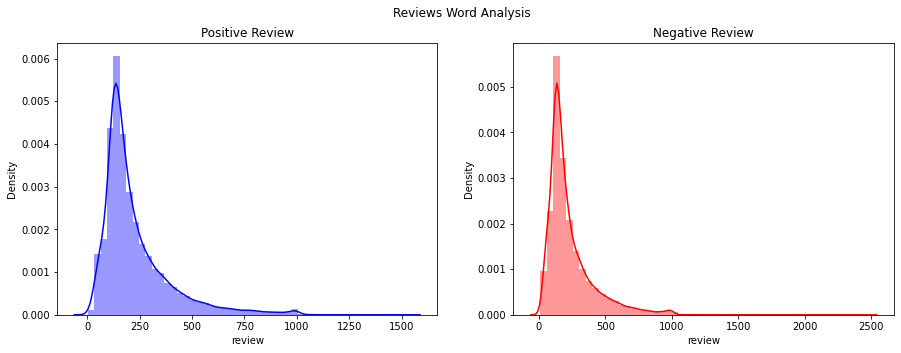

In [6]:
#Analyse the count of words in each segment- both positive and negative reviews
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


count_good=df[df['sentiment']=='positive']
count_bad=df[df['sentiment']=='negative']

count_good_words=count_good['review'].str.split().apply(lambda z:cal_len(z))
count_bad_words=count_bad['review'].str.split().apply(lambda z:cal_len(z))
plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")

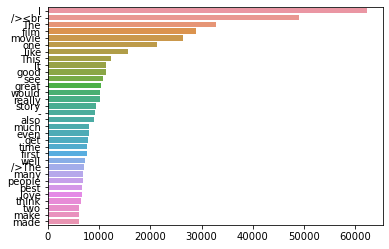

In [7]:
#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in df[df['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

stops=set(stopwords.words('english'))
corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.rcParams['figure.figsize'] = [15, 15]

It can be deduced from above that there are a considerable number of redundant words and html tags.

Check for emojis using an external library "advertools"

In [8]:
#Testing emojis
testEmojiDict = adv.extract_emoji("Hi ☺️ My name is Mo B. I love data science❤️💕😊😇😉😌😍🥰😗😙😚😚😋😛😝😜🤪🤨🧐😎")

count = 0
for emoji_count in testEmojiDict['emoji_counts']:
    if (emoji_count >= 1):
        count +=1
print("Total emojis:", count)
print(testEmojiDict['emoji_flat'])

Total emojis: 21
['☺', '❤', '💕', '😊', '😇', '😉', '😌', '😍', '🥰', '😗', '😙', '😚', '😚', '😋', '😛', '😝', '😜', '🤪', '🤨', '🧐', '😎']


In [ ]:
emoji_dict = adv.extract_emoji(df.review)

In [ ]:
count = 0

for emoji in emoji_dict['emoji_counts']:
    if (emoji >= 1):
        count +=1
print("Total emojis:", count)

print(emoji_dict['emoji_flat'])
print(emoji_dict['emoji_flat_text'])

Seems like they are no emojis in the dataframe. Bear in mind data has not been altered in any way as of yet. Only Registered and copyright symbols are found which would not have any effect on the sentiment analyser whatsoever. Therefore they will be removed

Considerable number of reviews contained HTML tags, as well as brackets. Therefore they are removed.
Special characters are removed as well.

In [9]:
#Removes the html strips
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removes URL
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removes special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def clean_text(text):
    text = remove_html(text)
    text = remove_url(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

#Apply function on review column
df['review'] = df['review'].apply(clean_text)

Tokenise and normalise words

In [10]:
#Complete stopword implementation and also include movie/season domain related stopwords such as film, movie, actress etc.
#Deal with abbreviation

nltk.download('punkt')
stemmer = EnglishStemmer()

def stem_words(tokenizedList):
    stemmedList = []
    for word in tokenizedList:
        stemmedList.append(stemmer.stem(word))
    return stemmedList


def remove_stopwords(text, is_lower_case=False):
    tokenizer=ToktokTokenizer()
    stopword_list=nltk.corpus.stopwords.words('english')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def smarter_tokenize_and_preprocess(text):
    filteredReview = remove_stopwords(text)
    tokenizedWords = nltk.word_tokenize(filteredReview)
    return stem_words(tokenizedWords)

df['review'] = df['review'].apply(smarter_tokenize_and_preprocess)

[nltk_data] Downloading package punkt to /Users/moham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


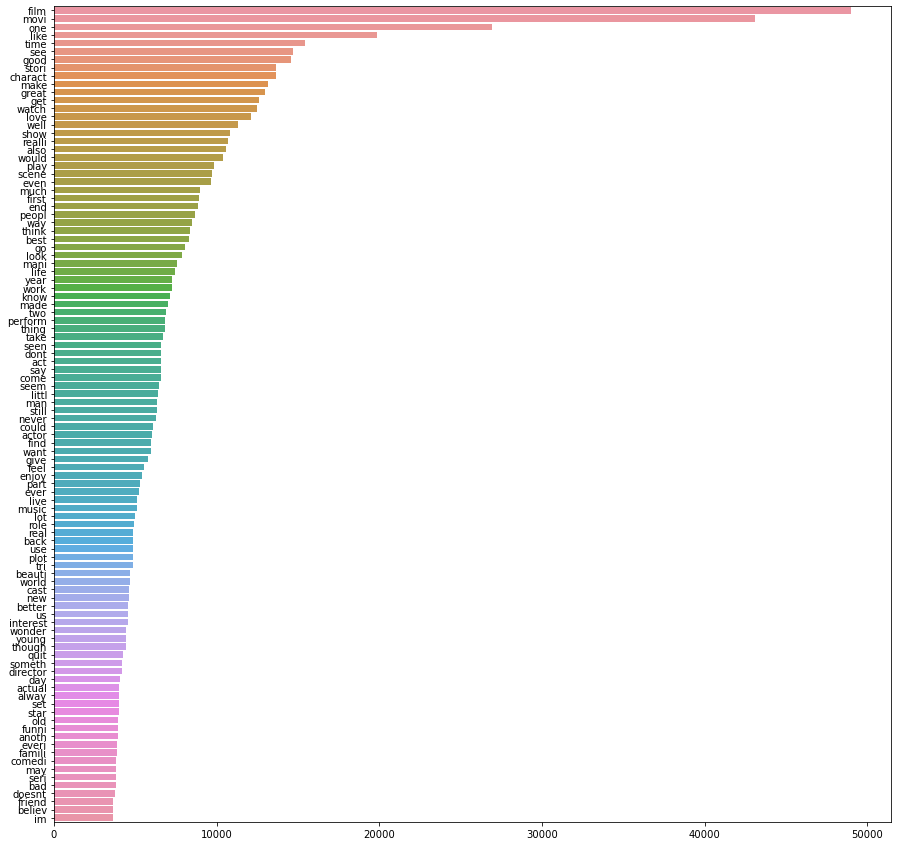

In [11]:
#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in df[df['sentiment']==word]['review']:
        for i in x:
            corpus.append(i)
    return corpus

stops=set(stopwords.words('english'))
corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.rcParams['figure.figsize'] = [15, 25]

It can be inferred that movie/season realted words are present in considerable words. Remove if needed

Possibly use tf-idf, can be used with logistic regression. More on that later when we pick a model

In [12]:
#split the dataset  
#train dataset
train_set=df[:40000]
#test dataset
test_set=df[40000:]
# test_sentiments=df.sentiment[40000:]
print(train_set.shape)
print(test_set.shape)

(40000, 2)
(10000, 2)


In [13]:
%%time

def identity_tokenizer(text):
    return text

tfidf_vect=TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, use_idf=True)    
train_tfidf=tfidf_vect.fit_transform(train_set['review'].values.tolist())
test_tfidf=tfidf_vect.transform(test_set['review'].values.tolist())

# # print idf values 
# df_idf = pd.DataFrame(train_tfidf.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
# # sort ascending 
# df_idf.sort_values(by=['idf_weights'])

# train_tfidf.shape

CPU times: user 3.34 s, sys: 186 ms, total: 3.53 s
Wall time: 3.74 s


In [14]:
print(train_tfidf)

  (0, 124067)	0.048579677212412395
  (0, 34718)	0.07815670542819243
  (0, 140273)	0.04926299746766431
  (0, 146978)	0.13042151521831186
  (0, 143467)	0.07398155888289235
  (0, 29558)	0.06753439426633133
  (0, 15550)	0.03957890659775265
  (0, 85383)	0.03888334709723334
  (0, 47390)	0.047337310462477813
  (0, 125145)	0.0599656050867133
  (0, 130939)	0.05477318861643465
  (0, 76955)	0.045044762505336663
  (0, 17730)	0.08248811178530012
  (0, 142130)	0.036955015229245096
  (0, 27839)	0.0547946440877073
  (0, 87535)	0.05446633301042307
  (0, 83965)	0.0591967350291995
  (0, 149748)	0.027404815134082088
  (0, 12953)	0.040339850575008766
  (0, 56703)	0.04874436667476364
  (0, 99367)	0.050263888437875874
  (0, 75377)	0.03965740182460602
  (0, 69702)	0.17171384758077157
  (0, 94494)	0.11117034912077345
  (0, 126678)	0.0730570405473652
  :	:
  (39999, 30027)	0.053345915442911805
  (39999, 111784)	0.05625266120452673
  (39999, 113936)	0.060523335279894744
  (39999, 134105)	0.0693326569852458
  (39

Convert data to binary

In [15]:
train_li=[]
for i in range(len(train_set)):
    if (train_set['sentiment'][i]=='positive'):
        train_li.append(1)
    else:
        train_li.append(0)
        
# test_li=[]
# for j in range(40000, len(test_set)):
#     if (test_set['sentiment'][j]=='positive'):
#         test_li.append(1)
#     else:
#         test_li.append(0)
        
test_li=[]
for sentiment in test_set.sentiment:
    if (sentiment == 'positive'):
        test_li.append(1)
    else:
        test_li.append(0)
        
train_set['Binary']=train_li
test_set['Binary']=test_li

/var/folders/8l/1gzp85r503b4q18n5sp6x6xh0000gn/T/ipykernel_2034/2263353046.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Binary']=train_li
/var/folders/8l/1gzp85r503b4q18n5sp6x6xh0000gn/T/ipykernel_2034/2263353046.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Binary']=test_li


In [16]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_tfidf, train_set['Binary'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_tfidf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test_set['Binary'], prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])

Training time: 1308.944148s; Prediction time: 140.673043s
positive:  {'precision': 0.8920094936708861, 'recall': 0.9007389654483723, 'f1-score': 0.8963529762496274, 'support': 5007}
negative:  {'precision': 0.8994741100323624, 'recall': 0.8906469056679351, 'f1-score': 0.8950387440877527, 'support': 4993}


In [ ]:
for c in [0.01, 0.02, 0.05, 0.25, 0.5, 0.75, 1]:
    svc = LinearSVC(C=c, max_iter=5000)
    print (f'At C = {c}:-', end=' ')
    fit_and_test(svc, X_train_onehot, y_train, X_test_onehot, y_test, True)